# Examen Parcial:

Para ejecutar el código: crear un kernel en la competencia de kaggle (https://www.kaggle.com/c/facial-keypoints-detection) y partir de este notebook. Una vez terminado, se debe descargar el notebook final y subirlo en paideia.


## Descripcion de la tarea

El objetivo de esta tarea es predecir las posiciones de los puntos clave en imágenes de rostros.

Las imágenes de entrada son de 96x96 píxeles y en escala de grises (descritas con números enteros entre 0 y 255).

Cada punto clave se especifica mediante un par de valores reales (x, y) en el espacio de los índices de píxeles. Hay 15 puntos clave, que representan los siguientes elementos de la cara:

    left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

De modo que se debe entrenar una red neuronal que tome como input la imagen en escala de grises y de como output 30 números (las coordenadas x,y de los 15 puntos claves).

Al compilar el modelo, especificar como función de pérdida el mean squared error **(mse)** y como métrica el mean absolute error **(mae)**. Por ejemplo:
``` python
model.compile(Adam(lr), loss='mse', metrics=['mae'])
```

## Calificación

- Normalizar las imágenes (1 pt)
- Definir correctamente la red neuronal (4 pts)
- Entrenar la red neuronal (2 pts)
  - mae entre 10 y 15 (3 pts)
  - mae entre 8 y 11 (5 pts)
  - mae entre 5 y 8 (7 pts)
  - mae menor o igual a 4.0 (9 pts)
- Mostrar 5 resultados aleatorios del set de validación (1 pt)
- Mostrar las 5 mejores predicciones del set de validación (1 pt)
- Mostrar las 5 peores predicciones del set de validación (1 pt)

## Recomendaciones

Activar el uso de GPU en el kernel de kaggle.

Dentro del kernel de kaggle, los botones para bajar y subir kernels, se encuentran en la parte superior de la pagina, a la izquierda del boton commit.

![](https://i.imgur.com/m4inkg3.png)

# Información de alumno
- Nombre: Alessandro Oscar Huamán Molina
- Código: 20141131
- Correo: alessandro.huaman@pucp.pe

# Lectura de datos

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../input/training/training.csv')
df.dropna(inplace=True)
df.shape

(2140, 31)

In [3]:
from joblib import Parallel, delayed

def format_img(x):
    return np.asarray([int(e) for e in x.split(' ')], dtype=np.uint8).reshape(96,96)

with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    x = ex(delayed(format_img)(e) for e in df.Image)
    
x = np.stack(x)[..., None]
x.shape

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    3.9s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:    6.9s
[Parallel(n_jobs=10)]: Done 2140 out of 2140 | elapsed:    8.0s finished


(2140, 96, 96, 1)

In [4]:
y = df.iloc[:, :-1].values
y.shape

(2140, 30)

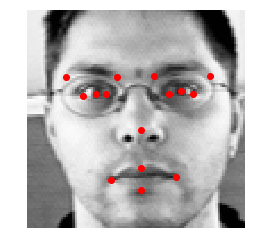

In [5]:
def show(x, y=None):
    plt.imshow(x[..., 0], 'gray')
    if y is not None:
        points = np.vstack(np.split(y, 15)).T
        plt.plot(points[0], points[1], 'o', color='red')
        
    plt.axis('off')

sample_idx = np.random.choice(len(x))    
show(x[sample_idx], y[sample_idx])

# Train validation split

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_val.shape

((1712, 96, 96, 1), (428, 96, 96, 1))

# Normalización de imágenes
Para ello se utiliza reshape de numpy para estirar las imagenes, normalizarlas y volver a dimensionarla como imagen

In [9]:
# Observamos las dimensiones de "y"
y_train.shape, y_val.shape

((1712, 30), (428, 30))

In [19]:
# Normalizar las imágenes (1pt)

# Opto por normalizar utilizando la media y las desviación estándar
# Estiramos las imágenes:
x_train_norm=x_train[:,:,:,:]
x_val_norm=x_val[:,:,:,:]
x_train_norm=x_train_norm.reshape([1712,96*96,1])
x_val_norm=x_val_norm.reshape([428,96*96,1])

# Normalización:
mu=x_train_norm.mean()
sigma=x_train_norm.std()

x_train_norm=(x_train_norm - mu)/sigma
x_val_norm=(x_val_norm - mu)/sigma # Se normaliza siempre con el mu y sigma de los datos de entrenamiento

x_train_norm.shape, x_val_norm.shape, x_train_norm.mean(), x_train_norm.std(), x_val_norm.mean(), x_val_norm.std()



((1712, 9216, 1),
 (428, 9216, 1),
 -9.338324506192905e-18,
 0.9999999999999999,
 -0.06512222683585148,
 0.9844637045228576)

In [20]:
# Observamos arriba que efectivamente están normalizados. Ahora retornamos a las dimensiones de matriz de imagen:
x_train_norm=x_train_norm.reshape([1712,96,96,1])
x_val_norm=x_val_norm.reshape([428,96,96,1])

x_train_norm.shape, x_val_norm.shape

((1712, 96, 96, 1), (428, 96, 96, 1))

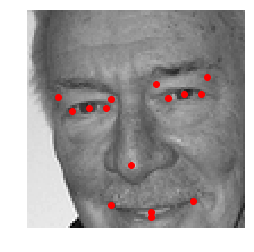

In [22]:
# Observamos una imagen para ver si está todo en orden:
show(x_train_norm[15], y_train[15])

Todo bien hasta ahora.

# Model
Notamos que se trata de un problema de regresión dado que los puntos faciales clave que debemos predecir tienen coordenadas X y Y (continuas). Entonces, la lógica de la red a construir será: convertir la imagen facial a las 30 coordenadas (output), comparándolas con el valor real mediante la pérdida MSE.

In [60]:
# Definir correctamente la red neuronal (5 pts)
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, AvgPool2D, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras import regularizers

model=Sequential([
    Conv2D(72,4,input_shape=(96,96,1),activation='relu'),
    AvgPool2D(pool_size=(2,2)),
    Conv2D(48,2,activation='relu',use_bias=False), #Según clase, no se debe inicializar bias antes de un batchnorm
    BatchNormalization(),
    Flatten(),
    Dropout(0.5), #Actúa como regularizador
    Dense(48,activation='relu', kernel_initializer='he_normal'), #Importante utilizar he initialization para relu
    Dense(30, kernel_initializer='he_normal') # No hay activación acá por ser un problema de regresión
])

model.compile(optimizer=Adam(0.01),loss='mse',metrics=['mae']) # Settings según indicaciones

In [61]:
# Resumen de las capas del modelo:
model.summary(), model.input, model.output

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 93, 93, 72)        1224      
_________________________________________________________________
average_pooling2d_9 (Average (None, 46, 46, 72)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 45, 45, 48)        13824     
_________________________________________________________________
batch_normalization_9 (Batch (None, 45, 45, 48)        192       
_________________________________________________________________
flatten_9 (Flatten)          (None, 97200)             0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 97200)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 48)                4665648   
__________

(None,
 <tf.Tensor 'conv2d_17_input:0' shape=(?, 96, 96, 1) dtype=float32>,
 <tf.Tensor 'dense_21/BiasAdd:0' shape=(?, 30) dtype=float32>)

In [62]:
# Entrenar la red neuronal (2 pts)
log=model.fit(x_train_norm, y_train, epochs=20, batch_size=256, validation_data=[x_val_norm,y_val])

Train on 1712 samples, validate on 428 samples
Epoch 1/20
1712/1712 [==============================] - 3s 2ms/step - loss: 7223.7339 - mean_absolute_error: 62.4429 - val_loss: 6447.2480 - val_mean_absolute_error: 57.5416
Epoch 2/20
1712/1712 [==============================] - 2s 905us/step - loss: 2514.4733 - mean_absolute_error: 44.4783 - val_loss: 2968.8990 - val_mean_absolute_error: 46.8773
Epoch 3/20
1712/1712 [==============================] - 2s 901us/step - loss: 1999.6566 - mean_absolute_error: 38.5359 - val_loss: 2844.7865 - val_mean_absolute_error: 43.5730
Epoch 4/20
1712/1712 [==============================] - 2s 901us/step - loss: 1247.0867 - mean_absolute_error: 28.1693 - val_loss: 1476.6318 - val_mean_absolute_error: 30.6214
Epoch 5/20
1712/1712 [==============================] - 2s 905us/step - loss: 547.3496 - mean_absolute_error: 18.2456 - val_loss: 857.2069 - val_mean_absolute_error: 23.3518
Epoch 6/20
1712/1712 [==============================] - 2s 901us/step - loss:

Nota para el profesor: Ojo que el modelo está entrenado para procesar adecuadamente datos normalizados, así que también normalizo el **x_val** para imprimir el error adecuado.

In [72]:
# Resultado del entrenamiento
# - mae entre 10 y 15 (3 pts)
# - mae entre 8 y 11 (5 pts)
# - mae entre 5 y 8 (7 pts)
# - mae menor o igual a 4.0 (9 pts)

print(f'MAE final: {model.evaluate(x_val, y_val)[1]}')
print(f'MAE final: {model.evaluate((x_val-mu)/sigma, y_val)[1]}')
print(f'MAE final: {model.evaluate(x_val_norm, y_val)[1]}')

428/428 [==============================] - 0s 560us/step
MAE final: 1233.9980970721379
428/428 [==============================] - 0s 444us/step
MAE final: 3.546432539681408
428/428 [==============================] - 0s 415us/step
MAE final: 3.546432539681408


Se observa entonces que se logra obtener un MAE menor a 4 (3.5462).

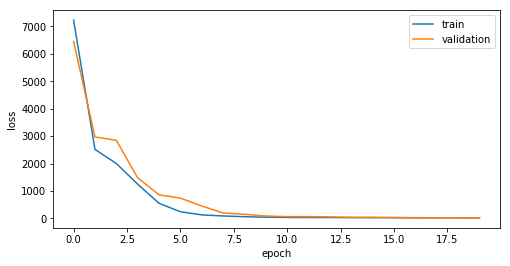

In [65]:
# Ver la perdida en el entrenamiento
def show_results(*logs):
    trn_loss, val_loss, trn_acc, val_acc = [], [], [], []
    
    for log in logs:
        trn_loss += log.history['loss']
        val_loss += log.history['val_loss']
    
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(trn_loss, label='train')
    ax.plot(val_loss, label='validation')
    ax.set_xlabel('epoch'); ax.set_ylabel('loss')
    ax.legend()
    
show_results(log)

# Resultados

In [66]:
# Función para visualizar un resultado
def show_pred(x, y_real, y_pred):
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    for ax in axes:
        ax.imshow(x[0, ..., 0], 'gray')
        ax.axis('off')
        
    points_real = np.vstack(np.split(y_real[0], 15)).T
    points_pred = np.vstack(np.split(y_pred[0], 15)).T
    axes[0].plot(points_pred[0], points_pred[1], 'o', color='red')
    axes[0].set_title('Predictions', size=16)
    axes[1].plot(points_real[0], points_real[1], 'o', color='green')
    axes[1].plot(points_pred[0], points_pred[1], 'o', color='red', alpha=0.5)
    axes[1].set_title('Real', size=16)

Ej:
``` python
sample_x = x_val[0, None]
sample_y = y_val[0, None]
pred = model.predict(sample_x)
show_pred(sample_x, sample_y, pred)
```

In [88]:
# Ordenamos el set de validación según el ranking de errores obtenidos al predecir el set de validación:
predicciones_val=model.predict(x_val_norm)
residuales_val=np.abs(predicciones_val - y_val)
mad_val=np.sum(residuales_val, axis=1)/30

indices=mad_val.argsort()
indices.shape

(428,)

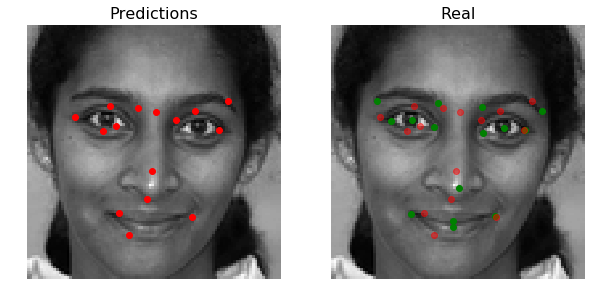

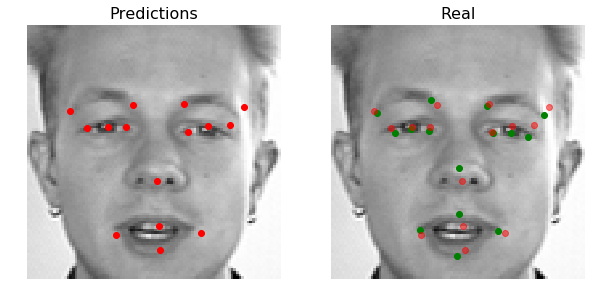

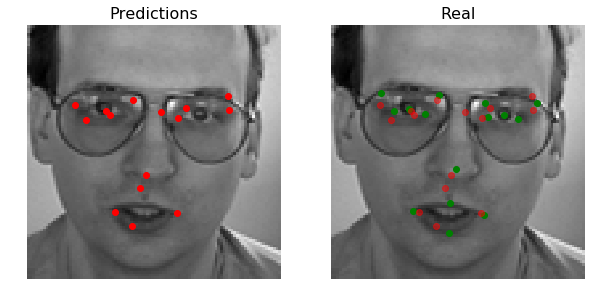

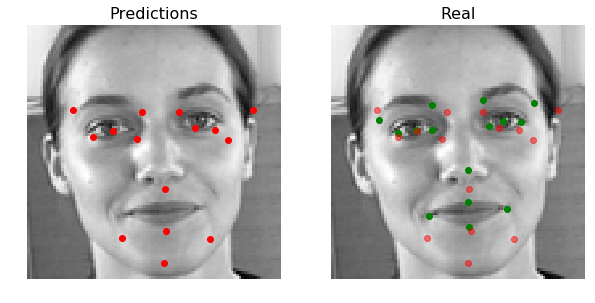

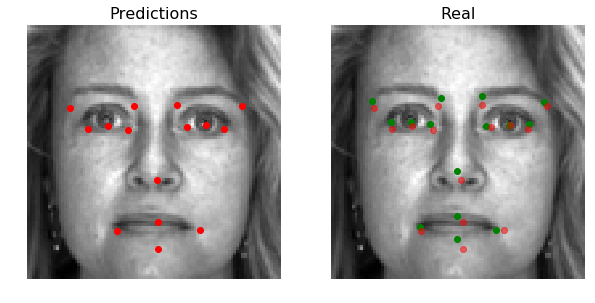

In [89]:
# Mostrar 5 resultados aleatorios del set de validación (1 pt)
for _ in range(5):
    index = np.random.choice(x_val_norm.shape[0])
    sample_x = x_val_norm[index, None]
    sample_y = y_val[index, None]
    pred = model.predict(sample_x)
    show_pred(sample_x, sample_y, pred)

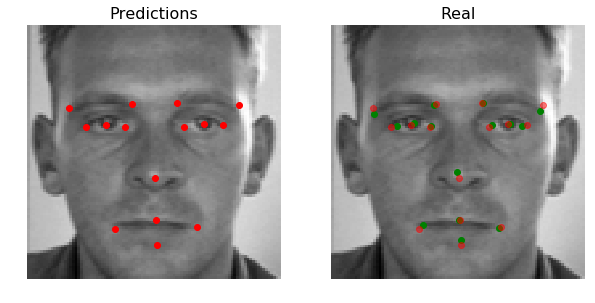

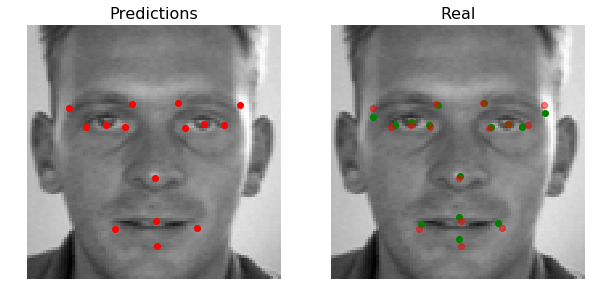

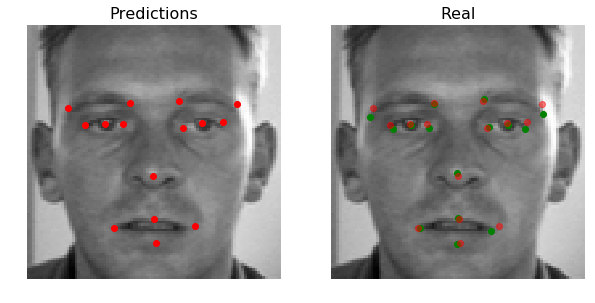

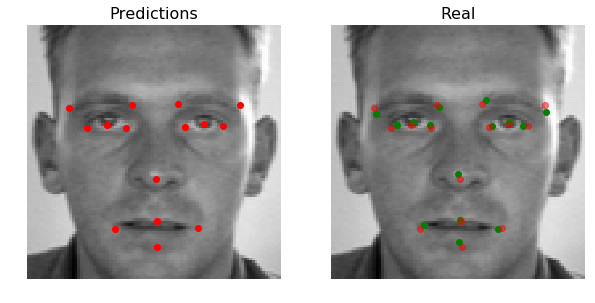

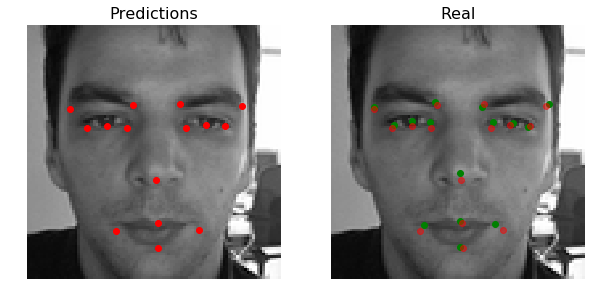

In [91]:
# Mostrar las 5 mejores predicciones del set de validación (1 pt)
for i in range(5):
    sample_x = x_val_norm[indices[i], None]
    sample_y = y_val[indices[i], None]
    pred = model.predict(sample_x)
    show_pred(sample_x, sample_y, pred)

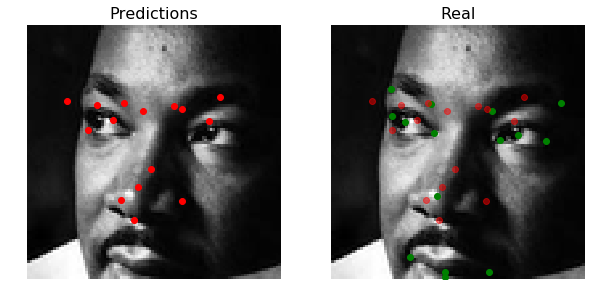

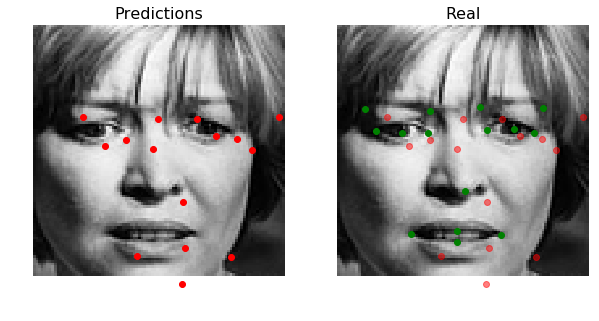

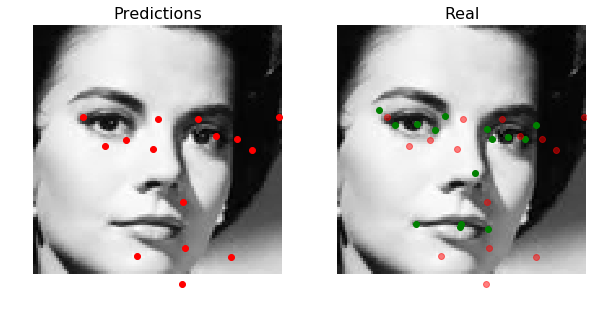

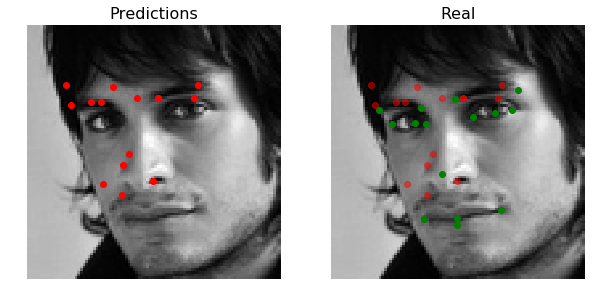

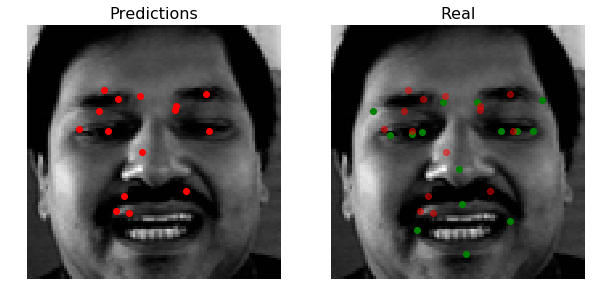

In [97]:
# Mostrar las 5 peores predicciones del set de validación (1 pt)
for i in [-1,-2,-3,-4,-5]:
    sample_x = x_val_norm[indices[i], None]
    sample_y = y_val[indices[i], None]
    pred = model.predict(sample_x)
    show_pred(sample_x, sample_y, pred)